# Predicting Fantasy Football Points for Flex Positions
By Brett Lauer and Akhil Kammela

## Introduction
Fantasy football is a game in which individuals become NFL team managers. It has become a nationwide pastime amongst families, coworkers, and friends alike. Essentially, before a season starts, everyone participating is involved in drafting a roster. They pick players from every offensive position, and select a team's defense as a whole. Every week, you select a starting lineup and watch them play. As they score touchdowns, run, pass, and catch, you accumulate points. The goal is to win every week in a one vs one by having the most points. Major sports media sites like ESPN and CBS release fantasy point predictions based on many factors to assist people in drafting. While Fantasy Football can be played casually, there are also online iterations in which people can play for real money. The main most popular sites are FanDuel and DraftKings. Both of these sites calculate each player's points differently.

## Motivation
Our goal is to do what ESPN and CBS do, but for DraftKings. Our focus is on Flex positions. These include tight end, wide receiver, and running back. The main reasons Flex is so important is that they are high scoring positions, and they all have similar in game statistics. We would like to utilize machine learning models to guess, based on players performance, how many points they will receive .We plan on looking at the 2013 through 2021 seasons to create our model, then test for accuracy and reliability using the 2022 season. In the future, someone attempting to gain an edge in DraftKings could use our model to predict points based on how a player has performed in previous seasons, and see to what degree the estimation is correct.

## Data Collection
Our data came from pro-football-reference.com. It is an open source website that has massive amounts of data for any sport or player. We decided to scrape our data using CSV files for each season. The tables include receiving, rushing, and touchdown statistics, along with overall points for fantasy, Fanduel, and DraftKings.

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("footballdata.csv", header=0)
df.head()

,Rk,Player,Tm,FantPos,Age,Games,GamesStart,PCmp,PAtt,PYds,...,2:00 PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank,Year
0,1,Patrick Mahomes*+,KAN,QB,27,17,17,435,648,5250,...,1,2,416,417.4,435.4,428.9,136,1,1,2022.0
1,2,Josh Jacobs*+,LVR,RB,24,17,17,0,0,0,...,NaN,NaN,275,328.3,335.3,301.8,127,1,2,2022.0
2,3,Christian McCaffrey*,2TM,RB,26,17,16,1,1,34,...,NaN,NaN,271,356.4,362.4,313.9,123,2,3,2022.0
3,4,Derrick Henry*,TEN,RB,28,16,16,2,2,4,...,NaN,NaN,270,302.8,311.8,286.3,122,3,4,2022.0
4,5,Justin Jefferson*+,MIN,WR,23,17,17,2,2,34,...,1,NaN,241,368.7,371.7,304.7,119,1,5,2022.0


## Data Cleanup
In order to create ML models, the data needs to be organized and presentable. As explained previously, we are only focusing on flex positions. We first need to drop all players that are quarterbacks, and also drop all passing statistics since flex players rarely throw the ball. Something that ML models struggle with often in dealing with missing values. There are a couple of options to remedy this, deleting the rows, using imputation, prediction, or replacement with zeroes. While usually unfavorable, we decided to fill missing values with zero. After close examination of the CSV file, the values that were missing were always in average scores. This meant that if the overall statistic was a zero, the table counted the average of that statistic as a missing value. For example, Josh Allen, the Bills quarterback, had zero receiving yards and therefore had a missing value for average receiving yards per game. Once the main issues were dealt with, we made tables for fantasy and Draftkings alike.

In [49]:
# Drop all passing stats
df_nopass = df.drop(["PCmp", "PAtt", "PYds", "PTD", "PInt"], axis = 1)
# Drop all QBs
df_noqb = df_nopass[df_nopass["FantPos"] != "QB"]
df_noqb = df_noqb.rename(columns={"2:00 PM": "2PM"})
# Drop any rows with NAN for scoring
df_noqb = df_noqb.dropna(subset=["FantPt", "PPR", "DKPt", "FDPt"])
# Remove filler rows
df_noqb = df_noqb[df_noqb["Rk"] != "Rk"]
# Give ID
df_noqb["id"] = df_noqb.index
df_noqb
# Make data pure game stats
pure_stats = df_noqb.drop(["Rk", "Player", "Tm", "VBD", "PosRank", "OvRank", "FantPos"], axis = 1)
# Count any NaN values as stats worth 0
pure_stats = pure_stats.fillna(0)
# Select only fantasy and DraftKings points
fantasy_stats = pure_stats.drop(["PPR", "DKPt", "FDPt"], axis=1).astype(float)
DK_stats = pure_stats.drop(["PPR", "FantPt", "FDPt"], axis=1).astype(float)
pure_stats



,Age,Games,GamesStart,RsAtt,RsYds,RsY/A,RsTD,RcTgt,RcRec,RcYds,...,FL,TD,2PM,2PP,FantPt,PPR,DKPt,FDPt,Year,id
1,24,17,17,340,1653,4.86,12,64,53,400,...,1,12,0,0,275,328.3,335.3,301.8,2022.0,1
2,26,17,16,244,1139,4.67,8,108,85,741,...,0,13,0,0,271,356.4,362.4,313.9,2022.0,2
3,28,16,16,349,1538,4.41,13,41,33,398,...,3,13,0,0,270,302.8,311.8,286.3,2022.0,3
4,23,17,17,4,24,6,1,184,128,1809,...,0,9,1,0,241,368.7,371.7,304.7,2022.0,4
5,27,17,17,204,915,4.49,13,127,107,722,...,3,18,0,0,266,372.7,381.7,319.2,2022.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6360,27,16,0,1,1,1,0,1,1,12,...,1,0,0,0,-1,0.3,1.3,-0.2,2013.0,6360
6361,24,13,0,0,0,0,0,3,2,14,...,1,0,0,0,-1,1.4,2.4,0.4,2013.0,6361
6363,29,8,0,0,0,0,0,2,1,4,...,1,0,0,0,-2,-0.6,0.4,-1.1,2013.0,6363
6366,29,9,0,1,0,0,0,2,1,4,...,1,0,0,0,-2,-0.6,0.4,-1.1,2013.0,6366


## Feature Selection and DraftKings
To verify that Fantasy points and DraftKings calculate points correctly, we decided to use SelectKBest feature selection. We decided to look at the top nine features, and compare them accordingly.

In [50]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split

# K best feature selection for fantasy points
X = fantasy_stats.drop(["FantPt", "id", "Year"], axis = 1)
y = fantasy_stats["FantPt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
fs = SelectKBest(score_func=f_regression, k=9)
fs.fit(X_train, y_train)
fs.get_support()
selected_feat = X_train.columns[(fs.get_support())]

for number, feature in enumerate(selected_feat):
    print(number + 1, feature)


1 GamesStart
2 RsAtt
3 RsYds
4 RsTD
5 RcTgt
6 RcRec
7 RcYds
8 RcTD
9 TD


In [51]:
# K best feature selection for fantasy points
X = DK_stats.drop(["DKPt", "id", "Year"], axis = 1)
y = DK_stats["DKPt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
fs = SelectKBest(score_func=f_regression, k=9)
fs.fit(X_train, y_train)
fs.get_support()
selected_feat = X_train.columns[(fs.get_support())]

for number, feature in enumerate(selected_feat):
    print(number + 1, feature)

1 Games
2 GamesStart
3 RsAtt
4 RsYds
5 RcTgt
6 RcRec
7 RcYds
8 RcTD
9 TD


While the features came out similar, there are some differences which confirms our suspicion that fantasy and DraftKings use different point models. The ordering is different and the DraftKings model decided that games played were important and that rushing touchdowns were not. The fact that they are similar is expected, as both point systems are made to give more points to players that performed better within games.

Before training our prediciton models, we first need to separate the data into 2022 and 2013-2021 datasets. This will give us a training and testing set to see how well our actual model works when applied to the most recent season.

In [52]:
# Creating test set with only 2022 DK points
df_2022DK = DK_stats[DK_stats["Year"] == 2022]
df_2022 = df_2022DK.drop(["DKPt"], axis=1)
df_2022 = df_2022[["Games", "GamesStart", "RsAtt", "RsYds", "RcTgt", "RcRec", "RcYds", "RcTD", "TD"]]
DK_test = df_2022DK["DKPt"].astype(float)
# Removing 2022 from training set
DK_train = DK_stats[DK_stats["Year"] != 2022]
DK_train = DK_train.drop(["id"], axis = 1)

## Kth Nearest Neighbor Regression
The first model we decided to train was a KNN model using regression. The main reason we needed to use regression is because our prediction label, DraftKings points, is not a binary value. The range of DraftKings points is between 0-400, so regression is the obvious path to pursue. For this model, we decided to use the features previously selected by SelectKBest. KNN works by finding the distance between a query and the points in the data, it then selects the specified number of examples closest to the query. This number is denoted by K. After selection, it votes on the most frequent outcome and makes a prediction.


## Selecting K
In order to select K, we want the model with the lowest error. We decided to use RSME (Root Mean Squared Error) as it shows the difference between predicted and actual. To analyze this, we checked neighbors 1-20 using a for loop, and plotted the results.


Text(0, 0.5, 'RSME')

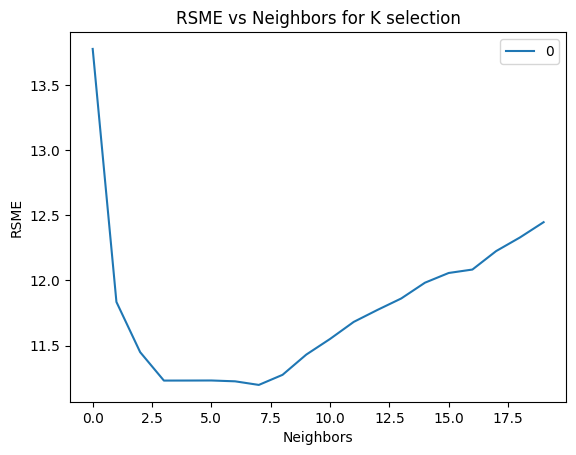

In [53]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from math import sqrt
# Redoing RF with KNN Regression
X = DK_train[["Games", "GamesStart", "RsAtt", "RsYds", "RcTgt", "RcRec", "RcYds", "RcTD", "TD"]].astype(float)
y = DK_train["DKPt"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = sqrt(mean_squared_error(y_test, pred)) 
    rmse_val.append(error)
curve = pd.DataFrame(rmse_val)
curve.plot()
plt.title("RSME vs Neighbors for K selection")
plt.xlabel("Neighbors")
plt.ylabel("RSME")

After running the model, it appears that the best K value is around 6-7. Using this amount of neighbors results in an RSME value of around 5, which is quite good considering we are predicting numbers in a large range. 

In [74]:
from sklearn.metrics import classification_report
## Finding model accuracys with optimized neighbors
reg = KNeighborsRegressor(n_neighbors=6)
reg.fit(X_train, y_train)
model_score = reg.score(X_test, y_test)
pred_score = reg.score(df_2022, DK_test)
print("Our model performed with an accuracy of" ,model_score, "and our model predicted the 2022 data with an accuracy of" ,pred_score)
#Display table of first 20 predicted DK values vs Actual Values
predKNN = reg.predict(df_2022)
df_KNN = pd.DataFrame({'Actual': DK_test, 'Predicted': predKNN})
pd.set_option('display.max_rows', 20)
df_KNN.head(20)

Our model performed with an accuracy of 0.9788651734830826 and our model predicted the 2022 data with an accuracy of 0.9837741216129847


,Actual,Predicted
1,335.3,330.166667
2,362.4,362.200000
3,311.8,294.483333
4,371.7,370.666667
5,381.7,310.700000
7,320.3,297.766667
8,338.5,324.600000
9,288.4,270.266667
10,350.2,353.333333
12,304.6,322.633333


## KNN Analysis
After running the actual model, we got quite good results. The training model had an accuracy of 98.2% and the trained model on the 2022 data had an accuracy of 98.4%. Overall, the model is successful in predicting DraftKings points which can be seen by the table above. Looking at pure numbers, we can see that many predicted point values are within ~10 of the actual value. KNN is great for pattern recognition, so the fact that it scored so high on accuracy is not surprising.


## Neural Networks

A Neural Network is multi-layer network of perceptrons that in the case of this project will be utilized to output DraftKings predictions given an input of 18 features of player stats. Regarding the efficacy of using Neural Networks under the context of sports & player performance predictions, there are many reports and projects that show the the model when used right is an effective technique in producing accurate predictions

examples: https://arxiv.org/pdf/2108.10125.pdf, https://chriszaire.medium.com/predicting-player-performance-using-neural-networks-f6142784b681) 

**End Goal with the Neural Network:** to train a network that when intaking the player stats for the 2022 Fantasy Football season provides an accurate set of predictions when compared to the 2022 DraftKings points per player. We will be analyzing the R_Squared MAE, and RMSE values of the model to examine its performance. Additionally we will be graphing the training loss to monitor model performance. 

*Terms:*

* *Residuals*: the difference between the actual value and the value predicted by the model (y-ŷ) for any given point 

* *r_squared*: also known as the coefficient of determination, r_squared displays how much of the variation of a dependent variable is explained by an independent variable in a regression model. The higher the value, the more  the model explains all the variability of the response data around its mean.

* *MAE*: the average over the test sample of the absolute differences between prediction and actual observation (the residuals) where all individual points have equal weight. 

* *RMSE*: quadratic scoring rule that also measures the average magnitude of the error. It’s the square root of the average of squared differences between prediction and actual observation. Because of the square, RMSE gives particularly higher weight to larger errors.

*Why MAE & RMSE?*
What is the purpose of observing both the MAE & RMSE values when analyzing model performance? Well generally we would need to use MAE to look at the average of the residuals, so how much the predictions of the model differ from the real world points. Now with the specific context of this project, outliers do matter to us. Being 50 points away from the predicted score cannot be considered the same as being 5 points away, hence RMSE is a useful metric for us to observe given how it treats outliers.

*Implementation*
For our implementation of the NN Regression model, we will be using MLPRegressor from the sklearn library. MLPRegressor is a multi-layer perceptron regressor with a wide variety of adjustable parameters (aka hyperparameters). 

The aim for this portion of the project is to setup a functional model, and a combination of the number of hidden layers/units and activation function type that provides the closest predictions to the 2022 DraftKings scores.

Lets first create and train a basic NN before we start looking to optimize accuracies

In [61]:
from sklearn.neural_network import MLPRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn import metrics
from sklearn import *

DK_target = DK_train["DKPt"]
DK_train = DK_train.drop(["DKPt"], axis = 1)

X = DK_train
y = DK_target

# Create training/ test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Instantiate MLPRegressor
nn = MLPRegressor(
    max_iter = 3000,
    activation='logistic',
    hidden_layer_sizes=(100,50,10),
)

# Train the model
nn.fit(X_train, y_train)

C:\Users\Hogs PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=(100, 50, 10),
             max_iter=3000)

So here we have a NN that utilizes logistic activation function, and has 3 hidden layers consisting of 100, 50, and 10 hidden units. Lets look at the performance of the model.

<Axes: title={'center': 'Training Loss Curve for Logistic Act. NN'}>

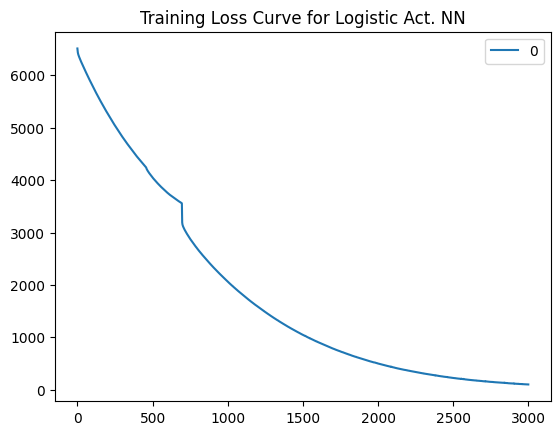

In [62]:
# print training loss curve
pd.DataFrame(nn.loss_curve_).plot(title = 'Training Loss Curve for Logistic Act. NN')

Here we can see that with the current parameters the model is in fact converging, as the iterations continue the models error is going down. While the curve is showing us that the model is performing well, it doesn't give an indication of how well our model will be able to predict future scores.

Lets look at how accurately the trained model predicts the 2022 DraftKings points based on 2022 player data.

In [63]:
# Make prediction
df_2022 = DK_stats[DK_stats["Year"] == 2022]
df_2022 = df_2022.drop(["DKPt", "id"], axis = 1)
predNN = nn.predict(df_2022)

In [64]:
#Display table of first 20 predicted DK values vs Actual Values
df_NN = pd.DataFrame({'Predicted': predNN,'Actual': DK_test})
pd.set_option('display.max_rows', 20)
df_NN.head(20)

,Predicted,Actual
1,251.246241,335.3
2,251.246241,362.4
3,251.239773,311.8
4,251.246607,371.7
5,251.245219,381.7
7,251.235088,320.3
8,251.246573,338.5
9,251.238344,288.4
10,251.246607,350.2
12,251.244839,304.6


Just by observing the table we can see that while some of the predicted value get close to the actual values, some of the residuals seem to be sizeable. Rather than eyeballing values, lets take a look at the RSquared, MAE, and RMSE values.

In [66]:
#calculate R_squared
rsquared = nn.score(df_2022, DK_test)
print('R_squared value: ', rsquared)

R_squared value:  0.9699309381063115


With the current model we yield an R_squared score of 96%. This basically means that the model explains most of the variability of the response data around its mean. Basically at its current state the predicted line of regression is doing a good job of fitting the actual points.

In [67]:
#Calculate MAE & RMSE values
mse = metrics.mean_squared_error(DK_test, predNN)
mae = metrics.mean_absolute_error(DK_test, predNN)
rmse = np.sqrt(mse)
print('MAE: ', mae)
print('RMSE: ', rmse)

MAE:  3.879497611356518
RMSE:  13.893863447935182


Looking at the MAE score, we can see that the average difference between the predicted and actual DK points is 7.8. Given how close the MAE and RMSE values are, this tells us that overall the outliers among the predicted points don't seem to be severe.

When it comes to all of the performance indicators we just examined, they stem from a NN model with not much attention paid to its parameters. In order to lower the average difference in value and overall get a more accurate values, we need to be able to use better parameters. We can acheieve this by creating a parameter grid and utilizing GridSearchCV. In regards to parameters we will be defaulting to using ReLU instead of Logistic as the activation function as ReLU has shown to be much more proficient in both speed and results.

We will be looking at a variety of hidden layer sizes, number of max iterations, and alpha values in determining the best set of parameters. (There are many other combinations of parameters we could search however we are bottlenecked by computing power, they take far too long).

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(150,100,50),(50,25,5),(100,50,10),(200,100,30)],
    'max_iter': [1000,2000,500],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001],
}

grid = GridSearchCV(nn, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_) 

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 25, 5), 'max_iter': 2000}


Here we find that our best set of parameters out of the few combinations we tested were 

1. alpha: 0.001
2. max_iter:1000
3. hidden_layer_sizes: 50, 25, 5

lets train this model and see how well it predicts the 2022 DK values

<Axes: title={'center': 'Training Loss Curve for ReLU Act. NN2'}>

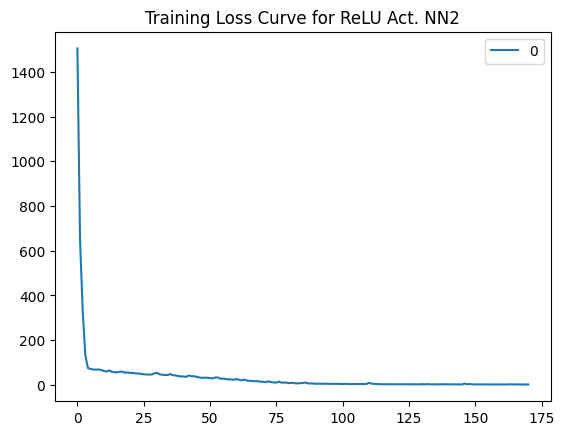

In [69]:
nn2 = MLPRegressor(
    max_iter = 1000,
    activation='relu',
    hidden_layer_sizes=(50,25,5),
    alpha=0.001,
)

# Train the model
nn2.fit(X_train, y_train)
# print training loss curve
pd.DataFrame(nn2.loss_curve_).plot(title = 'Training Loss Curve for ReLU Act. NN2')

With the newer model that utilizes the parameters we found from GridSearch we can see that the model converges much faster than the original Neural Network.

In [70]:
# Make prediction
predNN2 = nn2.predict(df_2022)

#calculate R_squared
rsquared = nn2.score(df_2022, DK_test)

#Calculate MAE & RMSE values
mse = metrics.mean_squared_error(DK_test, predNN2)
mae = metrics.mean_absolute_error(DK_test, predNN2)
rmse = np.sqrt(mse)

#Print the values
print('R_squared value: ', rsquared)
print('MAE: ', mae)
print('RMSE: ', rmse)

R_squared value:  0.9977869824448024
MAE:  3.3852695270945636
RMSE:  3.7692549707528618


Here we can see via the new R_squared score of 99.7% that the new model fits the actual points much better than before. Looking at both MAE and RMSE, the residuals have gotten much smaller than before, and given that MAE and RMSE is almost equal, this implies that there aren't many outliers (if there were outliers RMSE would be larger than MAE).

Now lets look at the values themselves.

In [71]:
#Display table of first 20 predicted DK values vs Actual Values
df_NN = pd.DataFrame({'Predicted': predNN2,'Actual': DK_test})
pd.set_option('display.max_rows', 20)
df_NN.head(20)

,Predicted,Actual
1,334.776158,335.3
2,364.139743,362.4
3,312.624387,311.8
4,381.167071,371.7
5,387.117466,381.7
7,324.992008,320.3
8,346.616089,338.5
9,295.639278,288.4
10,357.407625,350.2
12,312.889478,304.6


## Neural Network Reflection

Overall with the second Neural Network, we were able to build a model that can predict 2022 DraftKings point values that are accurate or at least within a close enough margin to deem the model as highly accurate as the error between the predicted and actual 2022 points is small. Looking at our process, we were successful in taking our first simple model, and choosing parameters that would minimize the size of the residuals, allowing for those closer predictions. In regards to shortcomings, it is important to note that there are a wide amount of parameters that weren't considered in the scope of this implementation and an even wider combination of parameter values, some of which could yield better predictions than our second model. In the future we would setup this project to levarge GPUs, which would allow us to compute the combinations of parameters to produce a better functioning prediction model.

## Model Comparison

In [76]:
# Creating a table for comparing models
names_2022 = df_noqb[df_noqb["Year"] == 2022]
names_2022 = names_2022["Player"]
df_Comp = pd.DataFrame({'Names': names_2022, 'Actual': DK_test, 'KNNPredicted': pred, 'NNPredicted': predNN2})
pd.set_option('display.max_rows', 20)
df_Comp.sort_values(by='Actual', ascending=False).head(20)

,Names,Actual,KNNPredicted,NNPredicted
5,Austin Ekeler,381.7,348.350000,387.117466
4,Justin Jefferson*+,371.7,352.766667,381.167071
2,Christian McCaffrey*,362.4,388.833333,364.139743
10,Tyreek Hill*+,350.2,346.000000,357.407625
8,Davante Adams*+,338.5,318.900000,346.616089
1,Josh Jacobs*+,335.3,330.166667,334.776158
7,Travis Kelce*+,320.3,279.283333,324.992008
13,Stefon Diggs*,319.6,300.233333,325.380920
3,Derrick Henry*,311.8,315.600000,312.624387
15,CeeDee Lamb*,304.6,285.250000,311.727560


# Conclusion & Future Work

Regarding the KNN and final Neural Network models, using sklearn's score function both models have shown to have great accuracy in predicting the 2022 DraftKings player points scores. While the models started off with lower performance, tuning hyperparameters and running exhaustive searches on parameter combinations allowed for our given acccuracies to be achieved. In the future we would like to further optimize these models, and even compare them against other regression models in an effort to product a predictor with higher accuracies, and test them on 2023 and future data.